# CAB420 Assignment 1A Question 1: Template
Simon Denman (s.denman@qut.edu.au)

## Overview

This notebook provides a brief template for CAB420 Assignment 1A, Question 1. It implements the data loading, and splitting the data into the predictors and response. You are to use the data splits defined here in your response.

The template also provides other suggestions around how to approach the problem.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

In [1]:
# import all the important packages

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn, because of excellent heatmaps
import seaborn as sns
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools


In [2]:
# Help Functions:
def standardise(data):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  mu = np.mean(data, axis=0)
  sigma = np.std(data, axis=0)
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

In [3]:
# load data
train = pd.read_csv('../A1/Data/Q1/communities_train.csv')
val = pd.read_csv('../A1/Data/Q1/communities_val.csv')
test = pd.read_csv('../A1/Data/Q1/communities_test.csv')

# Pull out X and y components of the data
# if you want to convert this data to numpy format, you can add .to_numpy() to the end of each row below
X_train = train.iloc[:,0:-1]
Y_train = train.iloc[:,-1]
X_val = val.iloc[:,0:-1]
Y_val = val.iloc[:,-1]
X_test = test.iloc[:,0:-1]
Y_test = test.iloc[:,-1]

Reasons to pre-process data:
1. Handling Missing Values: Linear regression cannot handle missing data directly, and missing values can bias the model or reduce data size unncessarily
2. Normalisation or Standardisation: Scaling improves numerical stabiliyt and regularized varients like Ridge or Lasso are sensitive to those
3. Removing Outliers: can have large impact on regression line leading to poor model performance

In [4]:
# Remove any type of NaN value from the dataset for a sanity check
print("Before NaN deletion", train.shape, val.shape, test.shape)
train = train.dropna(axis=0)
val = val.dropna(axis=0)
test = test.dropna(axis=0)
print("After NaN deletion, should be the same", train.shape, val.shape, test.shape)

Before NaN deletion (298, 101) (298, 101) (299, 101)
After NaN deletion, should be the same (298, 101) (298, 101) (299, 101)


In [5]:
# Using pandas to look at some information before modelling
train.describe()
# From looks of it, all values range from zero to 1 indicating that the data has been normalised, but given the mean of population and racePctWhite there is a huge gap, indicating 
# the need for standardisation as this will later penalise in both Ridge and Lasso Models, given we need to standardised for we must for regualr for fair evaulation

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,0.051174,0.470168,0.187550,0.740436,0.161846,0.155772,0.428523,0.494664,0.337752,0.428926,...,0.227282,0.603624,0.540638,0.624631,0.652047,0.063389,0.237919,0.167013,0.092416,0.231879
std,0.105366,0.174496,0.256605,0.247056,0.219377,0.259457,0.165588,0.147391,0.172498,0.189332,...,0.249737,0.205289,0.180099,0.203376,0.194945,0.096778,0.213516,0.244250,0.237379,0.212650
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.030000,0.050000,0.030000,0.020000,...,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.010000
25%,0.010000,0.350000,0.020000,0.592500,0.040000,0.010000,0.330000,0.410000,0.240000,0.300000,...,0.060000,0.450000,0.430000,0.530000,0.560000,0.020000,0.110000,0.020000,0.000000,0.070000
50%,0.020000,0.440000,0.050000,0.840000,0.075000,0.040000,0.395000,0.470000,0.290000,0.420000,...,0.130000,0.620000,0.555000,0.660000,0.705000,0.040000,0.170000,0.065000,0.000000,0.160000
75%,0.050000,0.550000,0.260000,0.940000,0.190000,0.140000,0.480000,0.550000,0.360000,0.530000,...,0.310000,0.780000,0.670000,0.770000,0.790000,0.070000,0.290000,0.190000,0.000000,0.340000
max,1.000000,1.000000,1.000000,0.990000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.950000,0.970000,0.960000,0.950000,1.000000,1.000000,1.000000,1.000000


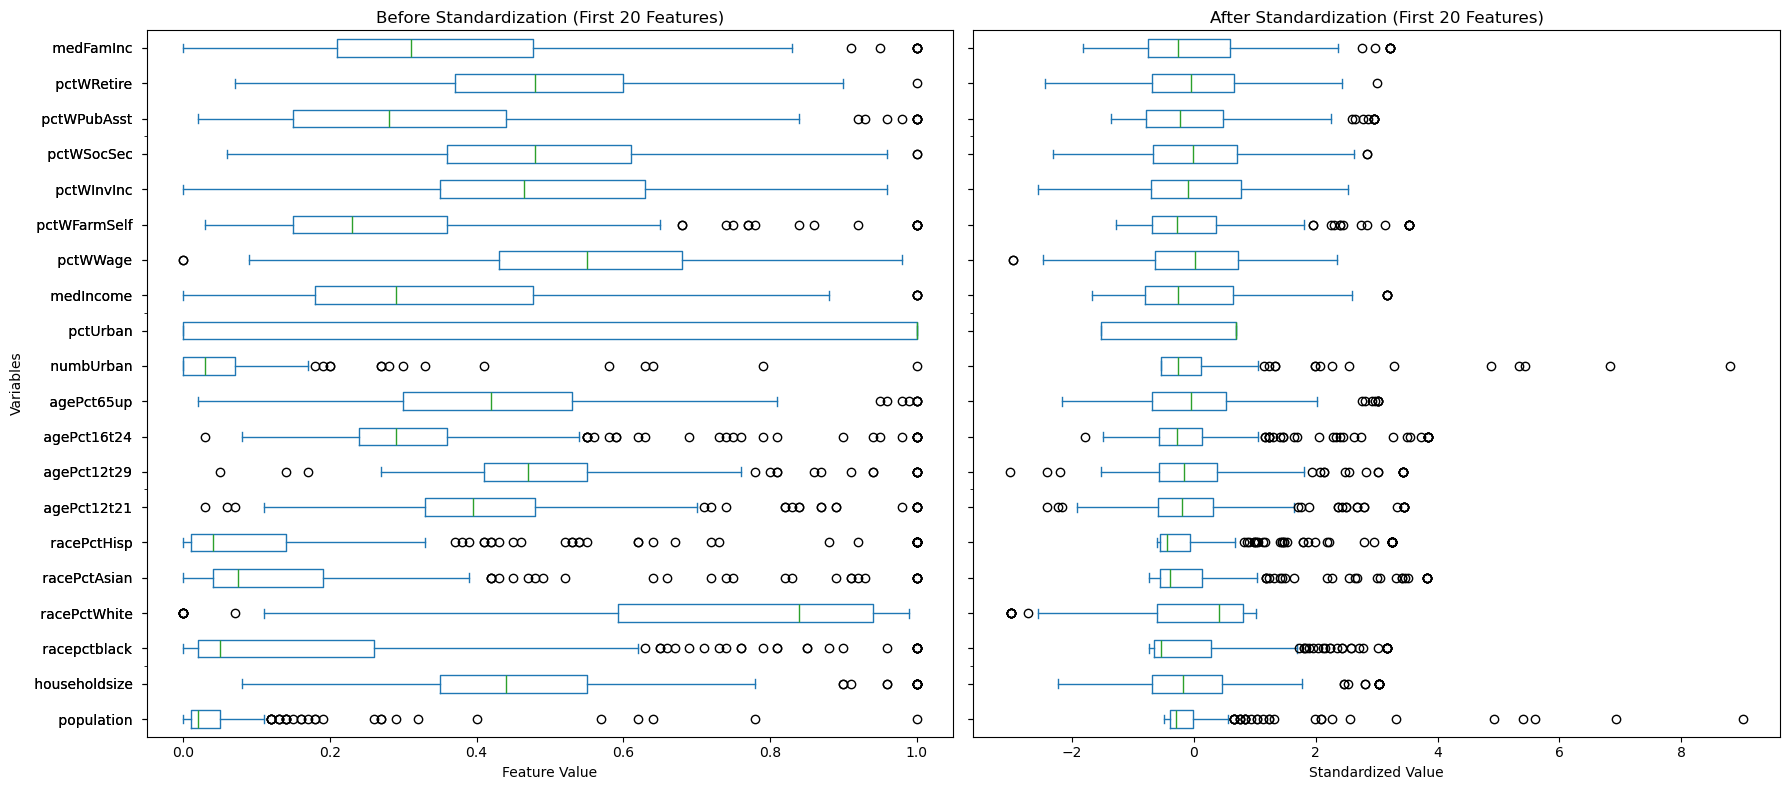

In [7]:
# Select first 20 features only
X_train_subset = X_train.iloc[:, :20]

# Standardize the subset
scaler = StandardScaler()
X_train_scaled_subset = pd.DataFrame(scaler.fit_transform(X_train_subset), columns=X_train_subset.columns)

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), sharey=True)

# Box plot of original (non-standardized) data
X_train_subset.plot(kind='box', vert=False, ax=axes[0])
axes[0].set_title('Before Standardization (First 20 Features)')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Variables')
# Box plot of standardized data
X_train_scaled_subset.plot(kind='box', vert=False, ax=axes[1])
axes[1].set_title('After Standardization (First 20 Features)')
axes[1].set_xlabel('Standardized Value')

# Clean layout
plt.tight_layout()
plt.show()

In [7]:
# Gathering all correlations between variables


In [8]:
def rmse(actual, pred):
  return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
  r2 = r2_score(actual, predicted)
  return r2

def adj_r2(actual, predicted, n, p):
  r2 = r2_score(actual, predicted)
  adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
  return adjr2
def evaluate_linear(x_train, y_train, x_val, y_val, x_test, y_test,
                    response_mu, response_sigma, title, alpha_list=None, L1_L2=None):
    """
    Evaluates a standard (non-regularised) linear regression model on the normalised data.
    
    This function fits a normal linear regression model (OLS) without any L1 or L2 regularisation,
    then computes and prints evaluation metrics (RMSE, R-squared, Adjusted R-squared) on the 
    training, validation, and test sets. It also produces diagnostic plots.
    
    Args:
      x_train (np.array): normalised predictor variable training data
      y_train (np.array): normalised response variable training data
      x_val (np.array): normalised predictor variable validation data
      y_val (np.array): normalised response variable validation data
      x_test (np.array): normalised predictor variable test data
      y_test (np.array): normalised response variable test data
      response_mu (np.array): mean value of the response variable (from training data)
      response_sigma (np.array): standard deviation of the response variable (from training data)
      alpha_list, L1_L2: not used in standard regression; kept for function signature compatibility.
    
    Returns:
      None
    """
    # Create the model using OLS (no regularisation)
    model = sm.OLS(y_train, x_train)
    
    # Fit the model using standard OLS fit (instead of fit_regularized)
    model_fit = model.fit()
    
    # Make predictions on training, validation, and test sets
    train_pred = model_fit.predict(x_train)
    val_pred = model_fit.predict(x_val)
    test_pred = model_fit.predict(x_test)
    
    # Extract coefficients and reshape as slope (assumes coefficients correspond to features)
    slope = np.array(model_fit.params).reshape(-1, 1)
    
    # Rescale predictions to original response scale
    pred_train_rescaled = (x_train @ slope) * response_sigma + response_mu
    pred_val_rescaled = (x_val @ slope) * response_sigma + response_mu
    pred_test_rescaled = (x_test @ slope) * response_sigma + response_mu
    
    # Calculate evaluation metrics
    r2 = r_squared(y_train * response_sigma + response_mu, pred_train_rescaled)
    adj_r2_val = adj_r2(y_train * response_sigma + response_mu, pred_train_rescaled,
                        x_train.shape[0], x_train.shape[1])
    rmse_val = np.sqrt(mean_squared_error(y_val * response_sigma + response_mu, pred_val_rescaled))
    rmse_test = np.sqrt(mean_squared_error(y_test * response_sigma + response_mu, pred_test_rescaled))
    
    # Print evaluation results
    print('Standard Linear Regression Evaluation on Normalised Data')
    print('R Squared (Train)      = {:.4f}'.format(r2))
    print('Adjusted R Squared (Train) = {:.4f}'.format(adj_r2_val))
    print('RMSE (Validation)      = {:.4f}'.format(rmse_val))
    print('RMSE (Test)            = {:.4f}'.format(rmse_test))
    print('Coefficients (slope)   = {}'.format(slope))
    
    # Now plotting diagnostic figures
    fig, axs = plt.subplots(4, figsize=(15, 25))
    
    # Plot predicted vs true values for test set (line plot)
    axs[0].plot(y_test * response_sigma + response_mu, label='Actual')
    axs[0].plot((x_test @ slope) * response_sigma + response_mu, label='Predicted')
    axs[0].legend()
    axs[0].set_title(title)
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Response Value')
    
    # Q-Q plot for the residuals on the training set
    train_pred_reshaped = (x_train @ slope).reshape(y_train.shape)
    resid = y_train - train_pred_reshaped
    sm.qqplot(resid, ax=axs[1], line='s')
    axs[1].set_title('Q-Q Plot for Linear Regression')
    
    # Residual plot for training set
    axs[2].scatter(train_pred_reshaped, resid)
    axs[2].set_title('Residuals for Training Set')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('Residuals')
    
    # Predicted vs True scatter plot for validation set
    axs[3].scatter(y_val * response_sigma + response_mu, (x_val @ slope) * response_sigma + response_mu, alpha=0.5)
    axs[3].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label='Ideal')
    axs[3].set_title('Predicted vs True (Validation Set)')
    axs[3].set_xlabel('True Values')
    axs[3].set_ylabel('Predicted Values')
    axs[3].legend()
    
    plt.show()

Notes: By the looks of it, we can now clearly see there is a large variation, whereas standardising it makes it better in terms of scaling. This is helpful for both lasso and ridge

In [9]:
# If you wish to pre-process the data, do so here. In your write-up, outline why you choose to do, or choose not to do, any
# pre-processing

# Removing constant term
X_train = np.delete(X_train, 0 ,1)
X_val = np.delete(X_val, 0, 1)
X_test = np.delete(X_test, 0, 1)

# Standardising
X_train_std, mu_train_x, sigma_train_x = standardise(X_train)
Y_train_std, mu_train_y, sigma_train_y = standardise(Y_train)
X_val_std = (X_val - mu_train_x)/sigma_train_x
Y_val_std = (Y_val - mu_train_y)/sigma_train_y
X_test_std = (X_test - mu_train_x)/sigma_train_x
Y_test_std = (Y_test - mu_train_y)/sigma_train_y

Non Standardised Linear Regression Model RMSE = 0.15363003954468835
                                  OLS Regression Results                                  
Dep. Variable:      ViolentCrimesPerPop    R-squared (uncentered):                   0.887
Model:                               OLS   Adj. R-squared (uncentered):              0.833
Method:                    Least Squares   F-statistic:                              16.51
Date:                   Sat, 05 Apr 2025   Prob (F-statistic):                    9.38e-60
Time:                           07:06:15   Log-Likelihood:                          246.82
No. Observations:                    298   AIC:                                     -301.6
Df Residuals:                        202   BIC:                                      53.29
Df Model:                             96                                                  
Covariance Type:               nonrobust                                                  
                 coef 

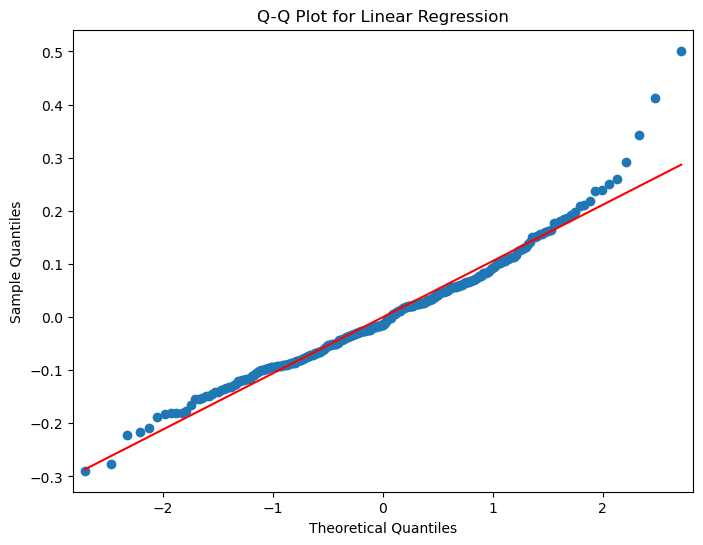

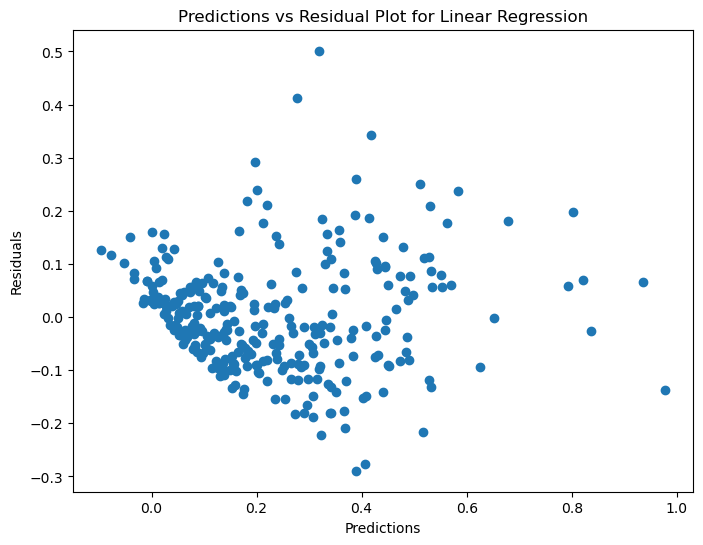

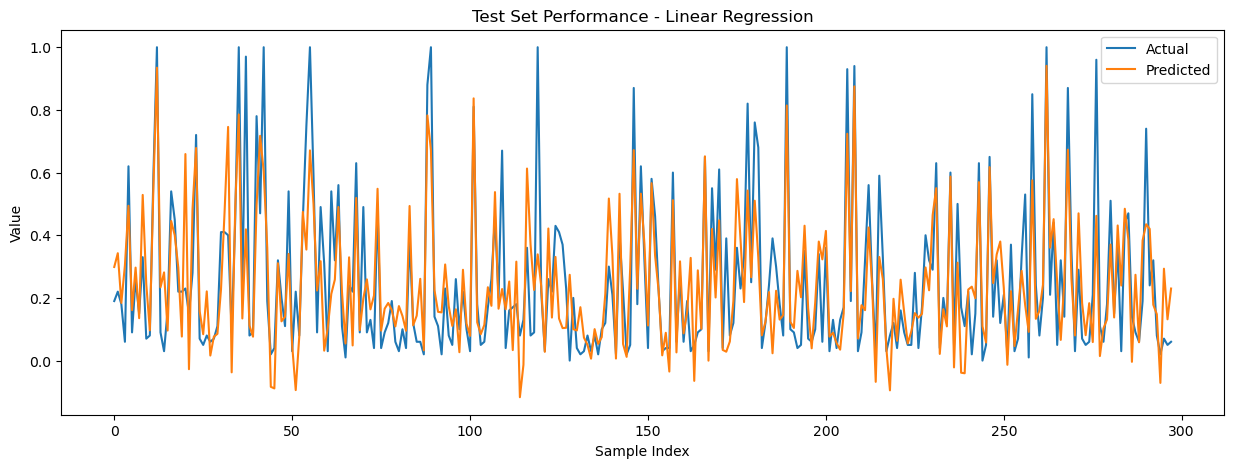

In [12]:
X_train = np.delete(X_train, 0 ,1)
X_val = np.delete(X_val, 0, 1)
X_test = np.delete(X_test, 0, 1)
# train your Linear Regression model here. Data has already been split into predictors (X_train, X_val and X_test) and the
# desired response (y_train, y_val and y_test above).
#
# Note that you DO NOT NEED to remove any variables, or add higher order terms. JUST USE THE DATA AS IS.
#

# Once you've trained the model, evaluate it. This would include:
#  - Measuring the accuracy of the model (i.e. RMSE or similar measures)
#  - Looking at the properties of the fitted model, for example the R^2, and if all terms are contributing to the model
#  - Considering the validity of the trained model. This could include assumptions about independent predictors, and the 
#    distribution of the residuals
# Your write-up should include your findings regarding the above.

# create the linear model
model = sm.OLS(Y_train, X_train)
# fit the model
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val)
print('Non Standardised Linear Regression Model RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_1_fit.predict(X_val)))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(model_1_fit.predict(X_train), model_1_fit.resid)
ax.set_xlabel('Predictions')
ax.set_ylabel('Residuals')
ax.set_title('Predictions vs Residual Plot for Linear Regression')

# Predicted Vs True Values
# Generate predictions on the validation (or test) set
y_val_pred = model_1_fit.predict(X_val)

# Create a line plot comparing actual vs. predicted
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual values
ax.plot(np.arange(len(Y_val)), Y_val, label='Actual')

# Plot predicted values
ax.plot(np.arange(len(Y_val)), y_val_pred, label='Predicted')

# Add labels and title
ax.set_xlabel('Sample Index')
ax.set_ylabel('Value')
ax.set_title('Test Set Performance - Linear Regression')
ax.legend()

plt.show()

In [13]:
# train your regularised models (ridge and lasso). Here you will use the same data as you used in for the above regression model
#
# One key consideration with your regularised models is the selection of lambda (i.e. the strength of the regularisation). A suggested 
# starting point for finding your value of lambda is suggested below using numpy.logspace (see 
# https://numpy.org/doc/stable/reference/generated/numpy.logspace.html). The code below will give you 50 values starting at 10-10 and 
# finishing at 1, spread on a log scale. Just note that for plotting things that result from this, you may want to change the scale of 
# your x-axis to a log scale (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html)
#
# Note that the below list of lambda is going to be fairly coarse. For the sake of speed, we suggest that you avoid evaluating a huge
# number of lambdas in one pass, but you can get a more precise estimate by refining your estimate over multiple passes (i.e. if your
# initial estimate if 0.1, you could run the search again now looking over a range of [0.01 .. 1.0] or similar). If you wish to do this,
# we suggest limiting yourself to 2-3 passes at most. You do not need to get the perfect value of lambda.
#
# remember that lambda is a keyword in python, so we're calling the array below alphas. 
#
alphas = np.logspace(-10, 0)

# Once you've found your ridge and lasso models, evaluate them, following the approach you've used for the linear method, and compare the
# three models.

# Ridge Model

In [21]:
def evaluate_regularisation(x_train, y_train, x_val, y_val, x_test, y_test,
                            response_mu, response_sigma, alpha_list, L1_L2, title):
    # Ridge: L1_L2 = 0
    # Lasso: L1_L2 = 1
    # create the model
    model = sm.OLS(y_train, x_train)
    # initialise the value for best RMSE that is obnoxiously large, as we want this be 
    # overwritten each time RMSE is smaller, since smaller is better and we want to 
    # update our best models each time the RMSE is smaller.
    best_rmse = 10e12
    best_alpha = []
    best_coeffs = []
    
    rmse_val = []
    rmse_train = []
    coeffs = []          # only needed for trace plots

    for alpha in alpha_list:
        model_cross_fit = model.fit_regularized(alpha=alpha, L1_wt=L1_L2)
        train_pred = model_cross_fit.predict(x_train)
        val_pred = model_cross_fit.predict(x_val)
        # want to append the rmse value to a list, as will plot all values later on
        rmse_train.append(np.sqrt(mean_squared_error(y_train, train_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(y_val, val_pred)))
        coeffs.append(model_cross_fit.params)
        # if this is the model with the lowest RMSE, lets save it
        if rmse_val[-1] < best_rmse:
            best_rmse = rmse_val[-1]
            best_alpha = alpha
            best_coeffs = model_cross_fit.params
            
    print('Best values on Validation Data set')
    slope = np.array(best_coeffs[0:]).reshape(-1, 1)
    pred_val_rescaled = (x_val @ slope) * response_sigma + response_mu
    pred_test_rescaled = (x_test @ slope) * response_sigma + response_mu
    pred_train_rescaled = (x_train @ slope) * response_sigma + response_mu
    best_r2 = r_squared(y_train * response_sigma + response_mu, pred_train_rescaled)
    best_adj_r2 = adj_r2(y_train * response_sigma + response_mu, pred_train_rescaled,
                           x_train.shape[0], x_train.shape[1]) 
    best_val_rmse = np.sqrt(mean_squared_error(y_val* response_sigma + response_mu, pred_val_rescaled))
    best_test_rmse = np.sqrt(mean_squared_error(y_test* response_sigma + response_mu, pred_test_rescaled))
    print('Best R Squared = {}'.format(best_r2))
    print('Best Adjusted = {}'.format(best_adj_r2))
    print('Best RMSE (val) = {}'.format(best_val_rmse))
    print('Best RMSE (test) = {}'.format(best_test_rmse))
    print('Best Lambda = {}'.format(best_alpha))
    print('Best coefficients on the normalised model')
    print('Best slope = {}'.format(slope))
    
    # now plotting some data
    fig, axs = plt.subplots(5, figsize=(8, 25))
    
    # plot the first values of alpha vs RMSE for train and validation data    
    axs[0].plot(np.array(alpha_list), rmse_train)
    axs[0].plot(np.array(alpha_list), rmse_val)
    axs[0].legend(['Training', 'Validation'])
    axs[0].set_title('RMSE vs Lambda')
    axs[0].set_xlabel('Lambda')
    axs[0].set_ylabel('RMSE')    
    
    # Set logarithmic scale for x-axis
    axs[0].set_xscale('log')   

    # plot prediction and true values for test set
    axs[1].plot((y_test*response_sigma + response_mu))
    axs[1].plot((x_test @ slope) * response_sigma + response_mu)
    axs[1].legend(['Actual', 'Predicted'])
    axs[1].set_title('Test Set Performance - ' + title)
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('Value')
    
    # plotting the Q-Q plot
    train_pred = (x_train @ slope).reshape(y_train.shape)
    resid = y_train - train_pred
    sm.qqplot(resid, ax=axs[2], line='s')
    axs[2].set_title('Q-Q Plot for LASSO Model')

    # plot the residuals as well
    axs[3].scatter(train_pred, resid)
    axs[3].set_title('Residuals vs Predicted LASSO Model')
    axs[3].set_xlabel('Predicted')
    axs[3].set_ylabel('Residuals')

    # trace plot of coefficients
    axs[4].plot(np.array(alpha_list), coeffs)
    axs[4].set_title('Trace Plot of Coefficients')
    axs[4].set_xlabel('Lambda')
    axs[4].set_ylabel('Coefficient Value')
    
    # Set logarithmic scale for x-axis of the trace plot
    axs[4].set_xscale('log')

    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()


Best values on Validation Data set
Best R Squared = 0.7201268073510785
Best Adjusted = 0.5801902110266177
Best RMSE (val) = 0.14241384183564387
Best RMSE (test) = 0.13179373223475058
Best Lambda = 0.05462277217684342
Best coefficients on the normalised model
Best slope = [[-0.0869738 ]
 [ 0.08581349]
 [-0.05400695]
 [ 0.00020527]
 [-0.18403482]
 [-0.0641711 ]
 [ 0.0478043 ]
 [ 0.06960106]
 [ 0.06228995]
 [ 0.00214965]
 [ 0.07491708]
 [ 0.0559967 ]
 [-0.0530478 ]
 [ 0.01574608]
 [-0.11043508]
 [ 0.06936723]
 [ 0.04837094]
 [-0.0872716 ]
 [ 0.02552286]
 [ 0.00993435]
 [ 0.0050028 ]
 [-0.00084364]
 [-0.03550294]
 [ 0.08885968]
 [ 0.00538446]
 [ 0.05210201]
 [-0.02314892]
 [-0.11810762]
 [-0.04830425]
 [ 0.03394015]
 [ 0.03895976]
 [-0.10198747]
 [ 0.13674974]
 [-0.07879232]
 [-0.00928352]
 [ 0.01367316]
 [-0.026178  ]
 [-0.01908868]
 [ 0.0088865 ]
 [-0.00734538]
 [-0.00999509]
 [ 0.07102847]
 [-0.10100899]
 [-0.12032144]
 [-0.07688173]
 [-0.01904639]
 [ 0.06384745]
 [-0.1044024 ]
 [ 0.061

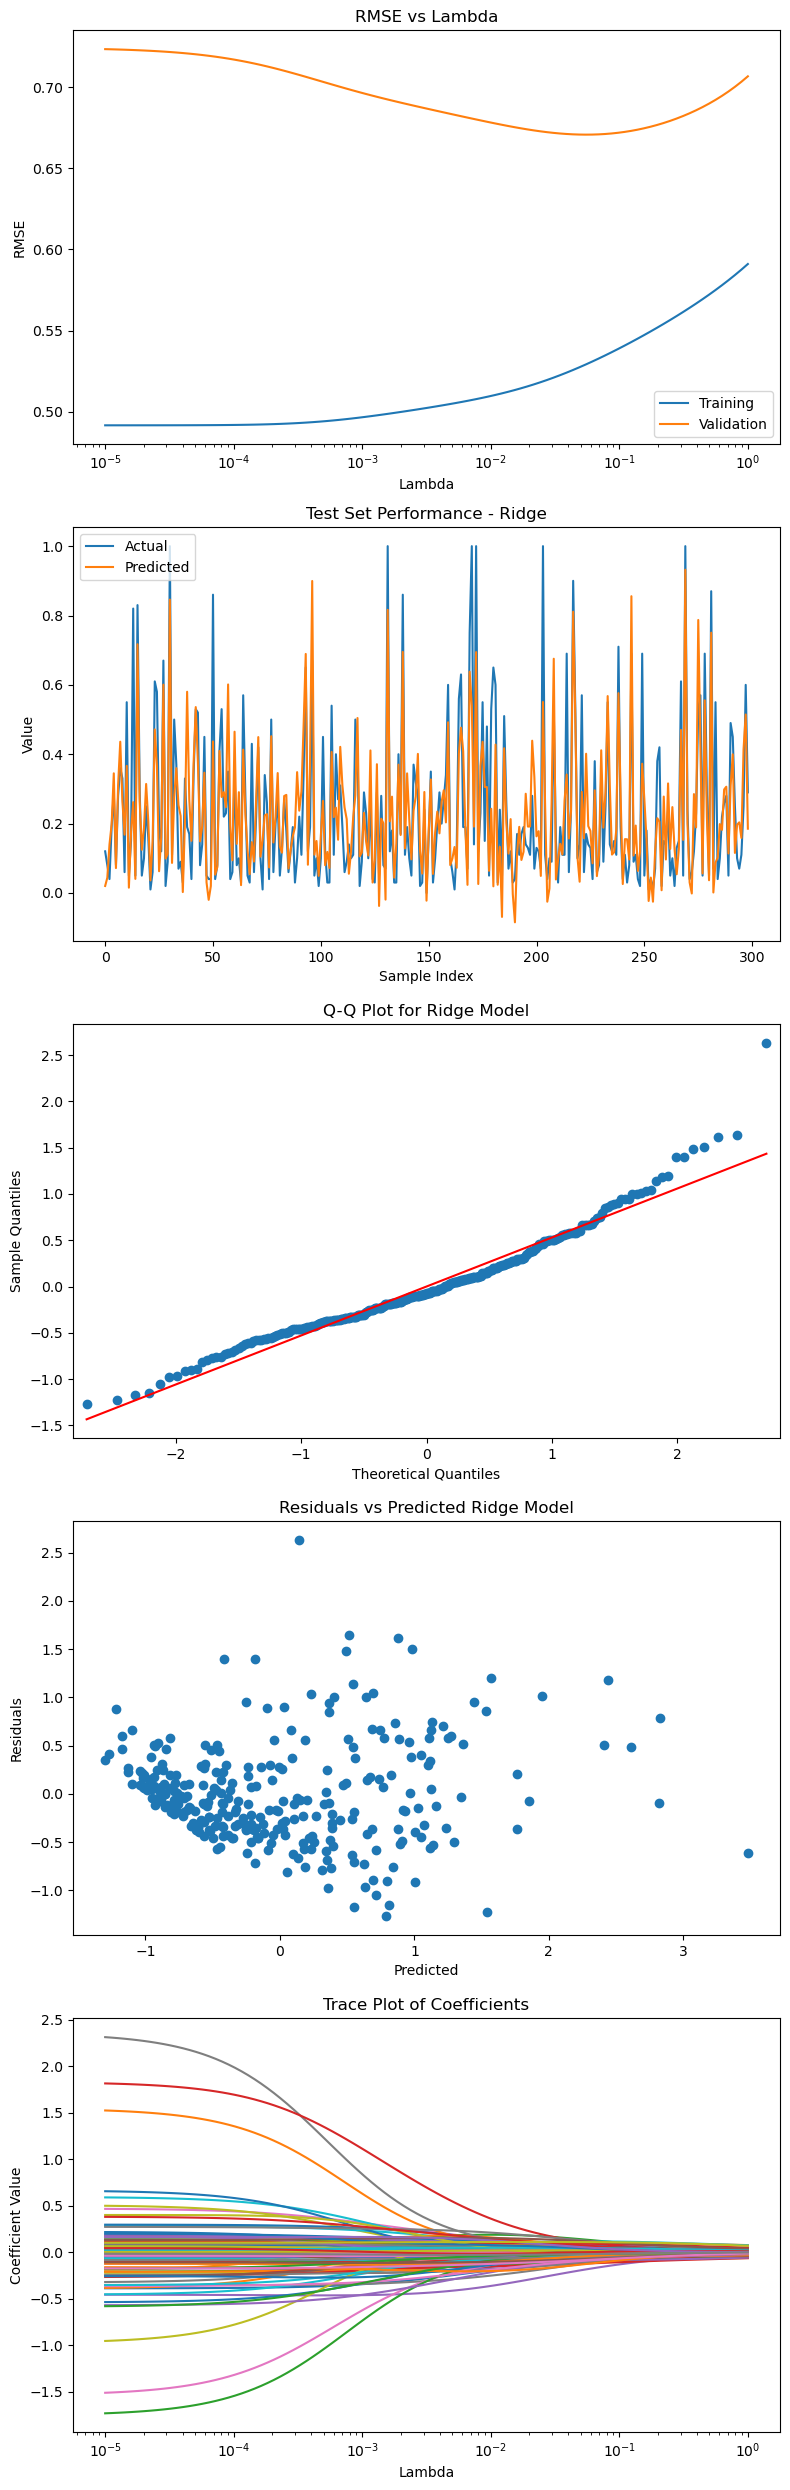

In [19]:
alpha_list = np.logspace(-5, 0, num = 100)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 0, 'Ridge')

# Lasso Model

Best values on Validation Data set
Best R Squared = 0.7144723213385153
Best Adjusted = 0.571708482007773
Best RMSE (val) = 0.14130967237263223
Best RMSE (test) = 0.13230388061382028
Best Lambda = 0.0009326033468832199
Best coefficients on the normalised model
Best slope = [[ 0.        ]
 [ 0.17278559]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.06477692]
 [ 0.        ]
 [ 0.12992522]
 [ 0.        ]
 [ 0.09294866]
 [ 0.02933168]
 [-0.07763306]
 [ 0.02867757]
 [-0.04817066]
 [ 0.        ]
 [ 0.        ]
 [-0.12147356]
 [ 0.        ]
 [-0.039358  ]
 [ 0.        ]
 [-0.00962172]
 [-0.04702949]
 [ 0.10839694]
 [ 0.00859905]
 [ 0.04889223]
 [ 0.03414018]
 [-0.26081281]
 [-0.0823334 ]
 [ 0.19165629]
 [ 0.13431248]
 [-0.08797621]
 [ 0.17484848]
 [-0.08294119]
 [ 0.        ]
 [ 0.        ]
 [-0.14184003]
 [-0.07078847]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.24424697]
 [-0.388997  ]
 [-0.0812226 ]
 [-0.10152349]
 [ 0.0154698 ]
 [ 0.12511859]
 [-0.21358319]
 [ 0.  

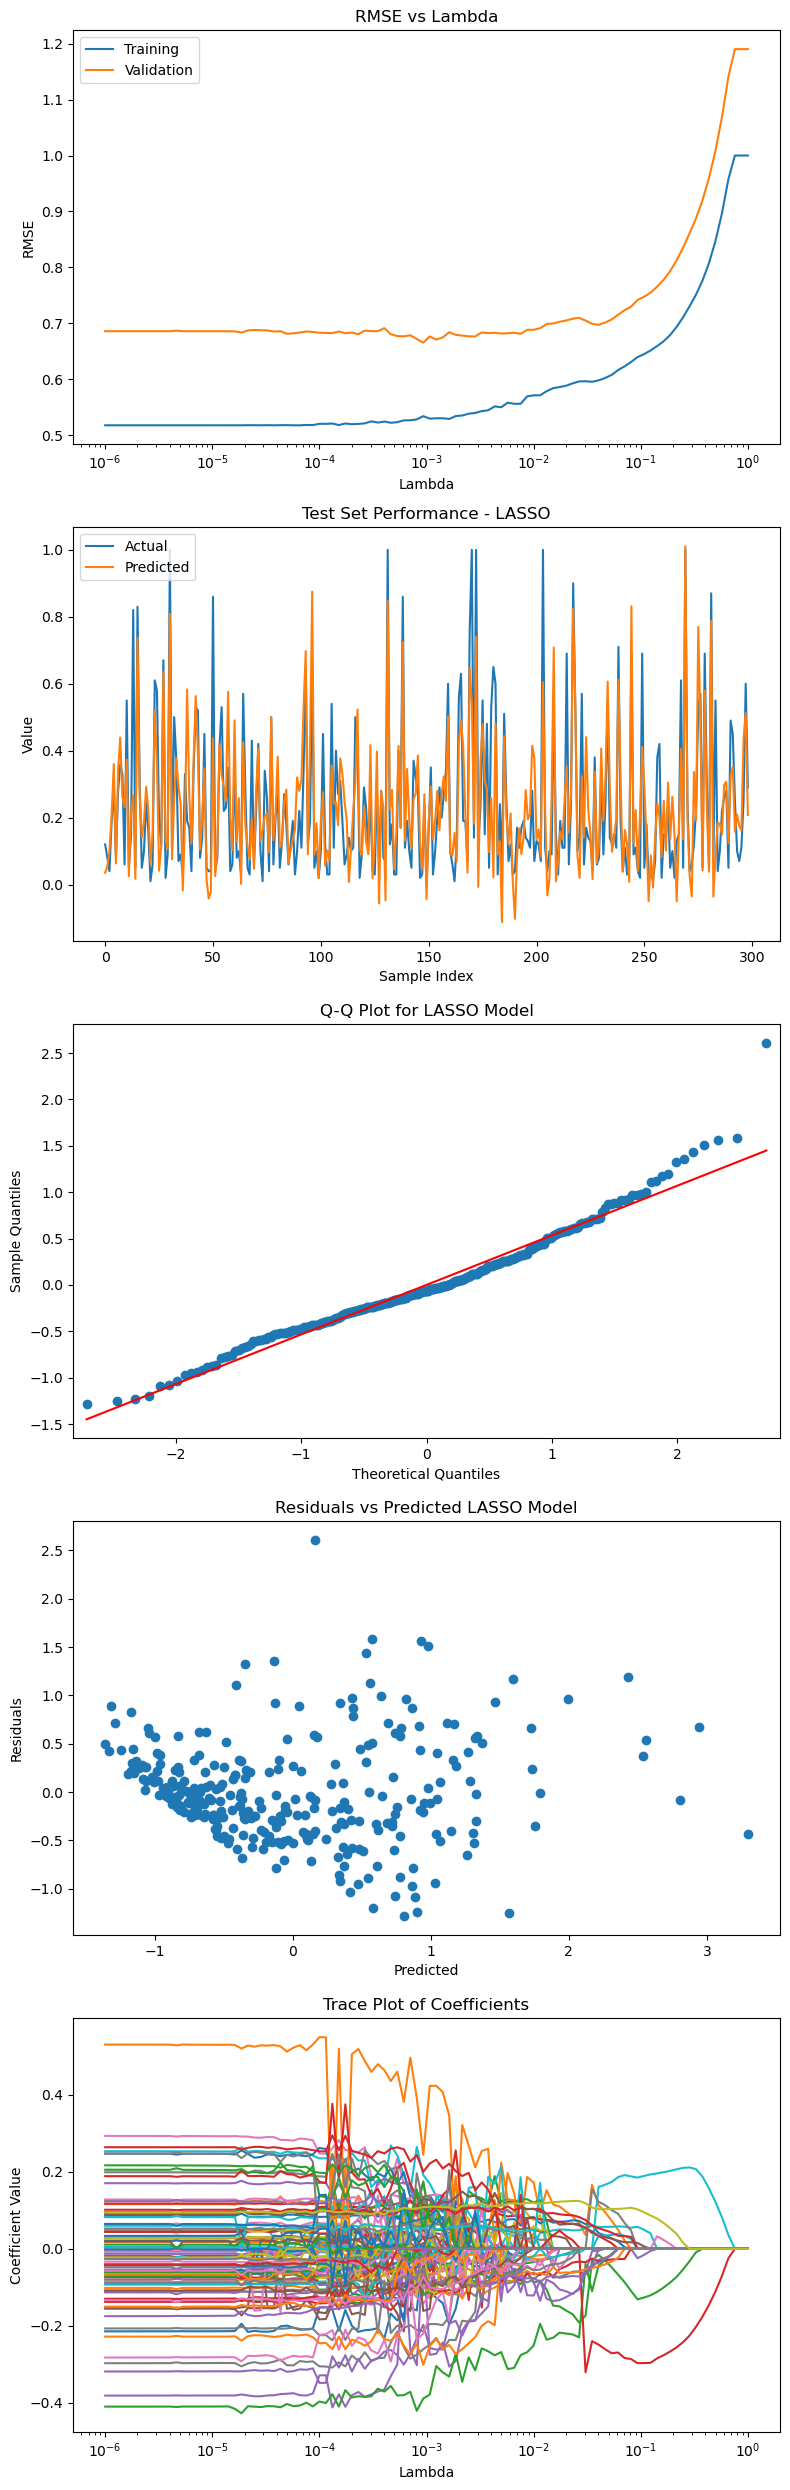

In [22]:
alpha_list = np.logspace(-6, 0, num = 100)
evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 1, 'LASSO')
# This lasso trace plot shows a strong coefficient sparsity as lambda increase
# Many features can be clearly shown to zero out early, suggesting Lasso
# is identifying small, relevant subset features. Lets zoom in 

Based on the trace plot of coefficients within the lambda range [0.0001, 0.1], we observe that a relatively large number of predictors remain active across the entire range. While some coefficeints shrink towards zero, there is no clear or consistent sparsity pattern emerging as lambda increase. The plot shows considerable fluctuattion in coefficient paths, and many features retain small but non-zero values.

This suggests that the current lambda range is sufficient for the Lasso model, as zooming in further would not yield meaningful simplification. Further decreasing lambda would liekly reintroduce instability and overfitting, while increasing it too much would eliminate informative predictors. Therefore, this lambda range strikes a reasonable balance between model sparisty and predictive performance. 

In [15]:
# For your write-up, you should include:
# - a discussion of any pre-processing you did and why; or why you left the data as-is
# - a discussion of how you selected the values of lambda used in your regularised models, and what those values are
# - a comparison of three models, considering both the accuracy and validity of the models, as outlined above, this means:
#   > accuracy of the model
#   > measures of fit, such as R^2
#   > testing assumptions about the independence of predictors, and the distribution of the residuals
# - A discussion of the ethical concerns that need to be considered when evaluating the models developed for this problem
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions. 
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT

In [16]:
# Add a confusion matrix of only a set amount to determine if there is a relationship between variables which
# Would violate the assumption of linear regression